In [1]:
import os
from collections import defaultdict
from PIL import Image
import numpy as np

In [2]:
from sklearn.preprocessing import OrdinalEncoder

In [209]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [4]:
from torchvision.transforms import transforms

In [5]:
from torch.utils.data import DataLoader

In [207]:
from scipy.stats import loguniform

In [330]:
class LFWClassificationDataset:
    def __init__(self, data_dir = ".\Data", image_count_threshold = 0, transforms = None, train = True):
        self.data_dir = data_dir
        self.image_count_threshold = image_count_threshold
        self.transforms = transforms
        self.train = train
        self._set_image_counts()
        self._filter_images()
        
    
    def _set_image_counts(self):
        if not self.data_dir:
            return None, None
        image_path_data = defaultdict(lambda : None)
        image_counts = defaultdict(lambda : 0)
        for data_dir, sub_dirs, files in os.walk(self.data_dir):
            image_file_counter = 0
            for file in files:
                if file.endswith("jpg"):
                    image_path = os.path.join(data_dir, file)
                    person_name = file[:-9]
                    image_file_counter += 1
                    image_path_data[(person_name, image_file_counter)] = image_path
                    image_counts[person_name] += 1
        self.image_counts = image_counts
        self.image_path_data = image_path_data
        return

    def _filter_images(self):
        self.filtered_image_counts = {person : image_counts for person, image_counts in self.image_counts.items() if image_counts >= self.image_count_threshold}
        filtered_image_paths = []
        filtered_person_labels = []
        for person_name, image_counts in self.image_counts.items():
            if image_counts >= self.image_count_threshold:
                for idx in range(1, image_counts + 1):
                    filtered_image_paths.append(self.image_path_data[(person_name, idx)])
                    filtered_person_labels.append(person_name)
        self.filtered_image_paths = filtered_image_paths
        self.filtered_person_labels = filtered_person_labels
        return
        
    def __getitem__(self, idx):
        image_path = self.filtered_image_paths[idx]
        label = self.filtered_person_labels[idx]
        
        with Image.open(image_path) as img:
            image_array = np.array(img, dtype = np.float64)/255
        if self.transforms:
            image_array = self.transforms(image_array)
        return image_array, label
    
    def __len__(self):
        return len(self.filtered_image_paths) 

In [331]:
custom_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [1, 1, 1]),
    # transforms.Lambda(lambda x : torch.permute(x, (2, 0, 1)))
])
lfw_dataset = LFWClassificationDataset(image_count_threshold=70, transforms = custom_transform)

In [332]:
from torch.utils.data import random_split

In [333]:
train_dataset, test_dataset = random_split(lfw_dataset, [0.7, 0.3])

In [334]:
len(train_dataset)

902

In [335]:
len(test_dataset)

386

In [336]:
train_dataloader = DataLoader(train_dataset, batch_size = 902, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 386, shuffle = True)

In [337]:
train_images, train_labels = next(iter(train_dataloader))
test_images, test_labels = next(iter(test_dataloader))

In [338]:
train_images = train_images.numpy()
test_images = test_images.numpy()

In [339]:
train_images.shape

(902, 3, 250, 250)

In [340]:
train_images = train_images.reshape(902, -1)
test_images = test_images.reshape(386, -1)

### PCA Eigen Faces

In [266]:
from sklearn.decomposition import PCA

In [175]:
pca = PCA(100, whiten = True)

In [176]:
train_images_transformed = pca.fit_transform(train_images)

In [178]:
eigen_faces = pca.components_.reshape(-1, 3, 250, 250).transpose(0, 2, 3, 1)

In [144]:
import matplotlib.pyplot as plt

In [179]:
face = eigen_faces[10]

In [180]:
face = (face - face.min())/(face.max() - face.min())

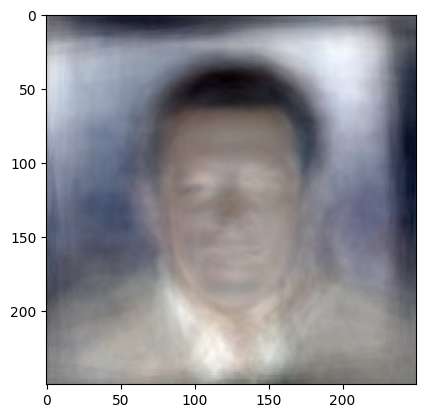

In [181]:
plt.imshow((face*255).astype(np.uint8))

In [341]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

In [342]:
from sklearn.compose import TransformedTargetRegressor

In [343]:
train_labels_prep = [[label] for label in train_labels]
test_labels_prep = [[label] for label in test_labels]

In [344]:
oe = OrdinalEncoder()
train_labels_prep = oe.fit_transform(train_labels_prep)
test_labels_prep = oe.transform(test_labels_prep)

In [361]:
scaler = StandardScaler()
lr_model = LogisticRegression()
rf_model = RandomForestClassifier(max_depth = 8)
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
pca = PCA(150, svd_solver = 'randomized', whiten = True)
lr_pipe = make_pipeline(scaler, pca, lr_model)
rf_pipe = make_pipeline(scaler, pca, rf_model)
svc_pipe = make_pipeline(scaler, pca, clf)

In [346]:
train_labels_prep = train_labels_prep.squeeze()

In [347]:
lr_pipe.fit(train_images, train_labels_prep)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca',
                 PCA(n_components=150, svd_solver='randomized', whiten=True)),
                ('logisticregression', LogisticRegression())])

In [348]:
test_preds = lr_pipe.predict(test_images)

In [349]:
test_labels_prep = test_labels_prep.squeeze()

In [350]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix

In [351]:
print(classification_report(test_labels_prep, test_preds))

              precision    recall  f1-score   support

         0.0       0.74      0.77      0.76        22
         1.0       0.93      0.83      0.88        76
         2.0       0.76      0.70      0.73        37
         3.0       0.86      0.96      0.91       162
         4.0       0.84      0.72      0.78        29
         5.0       0.69      0.65      0.67        17
         6.0       0.90      0.81      0.85        43

    accuracy                           0.85       386
   macro avg       0.82      0.78      0.80       386
weighted avg       0.85      0.85      0.85       386



In [352]:
test_preds_proba = lr_pipe.predict_proba(test_images)

In [353]:
roc_auc_score(test_labels_prep, test_preds_proba, multi_class = "ovr")

0.9706983067358692

In [354]:
rf_pipe.fit(train_images, train_labels_prep)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca',
                 PCA(n_components=150, svd_solver='randomized', whiten=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=8))])

In [355]:
test_preds = rf_pipe.predict(test_images)

In [356]:
test_preds_proba = rf_pipe.predict(test_images)

In [357]:
print(classification_report(test_labels_prep, test_preds))

              precision    recall  f1-score   support

         0.0       1.00      0.05      0.09        22
         1.0       0.87      0.26      0.40        76
         2.0       0.00      0.00      0.00        37
         3.0       0.45      1.00      0.62       162
         4.0       0.00      0.00      0.00        29
         5.0       0.00      0.00      0.00        17
         6.0       0.00      0.00      0.00        43

    accuracy                           0.47       386
   macro avg       0.33      0.19      0.16       386
weighted avg       0.42      0.47      0.34       386



C:\Users\vinod\.virtualenvs\FaceRecognition-ikLH-k2n\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vinod\.virtualenvs\FaceRecognition-ikLH-k2n\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vinod\.virtualenvs\FaceRecognition-ikLH-k2n\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [362]:
svc_pipe.fit(train_images, train_labels_prep)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca',
                 PCA(n_components=150, svd_solver='randomized', whiten=True)),
                ('randomizedsearchcv',
                 RandomizedSearchCV(estimator=SVC(class_weight='balanced'),
                                    param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000018D9F67E090>,
                                                         'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000018D9F6245D0>}))])

In [363]:
test_labels = svc_pipe.predict(test_images)

In [364]:
print(classification_report(test_labels_prep, test_preds))

              precision    recall  f1-score   support

         0.0       1.00      0.05      0.09        22
         1.0       0.87      0.26      0.40        76
         2.0       0.00      0.00      0.00        37
         3.0       0.45      1.00      0.62       162
         4.0       0.00      0.00      0.00        29
         5.0       0.00      0.00      0.00        17
         6.0       0.00      0.00      0.00        43

    accuracy                           0.47       386
   macro avg       0.33      0.19      0.16       386
weighted avg       0.42      0.47      0.34       386



C:\Users\vinod\.virtualenvs\FaceRecognition-ikLH-k2n\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vinod\.virtualenvs\FaceRecognition-ikLH-k2n\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vinod\.virtualenvs\FaceRecognition-ikLH-k2n\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

#### Building a simple cnn network

In [11]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.functional as F
torch.set_printoptions(sci_mode=False)

In [12]:
class ImageClassifier(nn.Module):
    def __init__(self, n_channels = 3, n_classes = 5):
        super().__init__()
        self.cnn_block = nn.Sequential(
            nn.Conv2d(3, 32, 5, padding = 2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 16, 5, padding = 2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, 5, padding = 2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 1, 5, padding = 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.linear_block = nn.Sequential(
            nn.Linear(225, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, n_classes)
        )
        
    def forward(self, x):
        x = self.cnn_block(x)
        return self.linear_block(x)

In [8]:
from torchvision.transforms import transforms

In [17]:
from torch.utils.data import random_split

In [19]:
random_split?

Signature:
random_split(
    dataset: torch.utils.data.dataset.Dataset[~T],
    lengths: Sequence[Union[int, float]],
    generator: Optional[torch._C.Generator] = <torch._C.Generator object at 0x000001A97535DF10>,
) -> List[torch.utils.data.dataset.Subset[~T]]
Docstring:
Randomly split a dataset into non-overlapping new datasets of given lengths.

If a list of fractions that sum up to 1 is given,
the lengths will be computed automatically as
floor(frac * len(dataset)) for each fraction provided.

After computing the lengths, if there are any remainders, 1 count will be
distributed in round-robin fashion to the lengths
until there are no remainders left.

Optionally fix the generator for reproducible results, e.g.:

Example:
    >>> # xdoctest: +SKIP
    >>> generator1 = torch.Generator().manual_seed(42)
    >>> generator2 = torch.Generator().manual_seed(42)
    >>> random_split(range(10), [3, 7], generator=generator1)
    >>> random_split(range(30), [0.3, 0.3, 0.4], generator=generato

In [14]:
custom_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [1, 1, 1]),
    # transforms.Lambda(lambda x : torch.permute(x, (2, 0, 1)))
])
lfw_dataset = LFWClassificationDataset(image_count_threshold=100, transforms = custom_transform)
lfw_dataset.train = True
train_loader = DataLoader(lfw_dataset, batch_size = 32, shuffle = True)
lfw_dataset.train = False
test_loader = DataLoader(lfw_dataset, batch_size = 32, shuffle = True)

In [10]:
torch.cuda.empty_cache()

In [ ]:
test_loader = DataLoader(lfw_dataset)

In [13]:
### Training loop
device = "cuda" if torch.cuda.is_available() else "cpu"
n_epochs = 2
n_classes = len(lfw_dataset.oe.categories_[0])
model = ImageClassifier(3, n_classes)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.0005)
criterion = nn.CrossEntropyLoss()

In [49]:
for epoch in range(epochs):
    for train_images, train_labels in train_loader:
        model.train()
        train_X = train_images.to(device)
        train_y = train_labels.to(device)
        optimizer.zero_grad()
        train_preds = model.forward(train_X)
        loss = criterion(train_preds, train_y.flatten().long())
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            print(f"loss - {loss.detach()}")

loss - 0.03003832697868347
loss - 0.03476151078939438
loss - 0.04211142286658287
loss - 0.020566878840327263
loss - 0.052327875047922134
loss - 0.04060576483607292
loss - 0.0636601448059082
loss - 0.04813740402460098
loss - 0.05377689749002457
loss - 0.041957609355449677
loss - 0.014923462644219398
loss - 0.01195528730750084
loss - 0.01033100951462984
loss - 0.02243342064321041
loss - 0.08147655427455902
loss - 0.09773536771535873
loss - 0.018824458122253418
loss - 0.03189332038164139
loss - 0.013434162363409996
loss - 0.02808016538619995
loss - 0.07341164350509644
loss - 0.07938715815544128
loss - 0.012464738450944424
loss - 0.10369575023651123
loss - 0.03113248571753502
loss - 0.003935069311410189
loss - 0.02859785594046116
loss - 0.032969068735837936
loss - 0.03844514489173889
loss - 0.04809367284178734
loss - 0.04664171487092972
loss - 0.1665048748254776
loss - 0.0332692451775074
loss - 0.03280729800462723
loss - 0.032440848648548126
loss - 0.03242354840040207


In [100]:
loss = nn.CrossEntropyLoss()

In [101]:
input1 = torch.randn(3, 5, requires_grad=True)

In [102]:
input1

tensor([[ 0.1086, -0.2144,  0.0132, -0.0779,  0.6264],
        [-0.7692, -0.0457, -0.4714,  1.2242,  1.2747],
        [ 0.4523,  1.3948, -0.1085,  0.4255, -0.3532]], requires_grad=True)

In [103]:
target = torch.empty(3, dtype=torch.long).random_(5)

In [104]:
target

tensor([2, 0, 3])

In [105]:
output = loss(input1, target)

In [106]:
output

tensor(2.1478, grad_fn=<NllLossBackward0>)

In [ ]:
output = loss(input, target)
>>> output.backward()
>>>
>>> # Example of target with class probabilities
>>> input = torch.randn(3, 5, requires_grad=True)
>>> target = torch.randn(3, 5).softmax(dim=1)
>>> output = loss(input, target)
>>> output.backward()